In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
import scipy

from os import path

from types import SimpleNamespace 
from utils import *
from hash_utils import digest

In [2]:
USE_AUTOGRAD = False

if USE_AUTOGRAD:
    import autograd.numpy as np 
    from autograd import grad, jacobian
    from autograd.builtins import isinstance, tuple

else:
    import numpy as np

In [3]:
# stuff for display

from IPython.lib.pretty import pretty, pprint

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [4]:
refresh_rp_file = False

rp_file_id = "1kBrPl0pdAO8gjOf_NrTgAPseFtqQA27fdfEbMBBeAhs"

sheet_ids = {
    "data_1_9":   "1682088244",
    "data_10_29": "1691041080",
}

local_files = {
    "data":       './data/rp-data.pickle',
}


if (refresh_rp_file):

    data_1_9 = download_sheet(rp_file_id, sheet_ids["data_1_9"])
    data_10_29 = download_sheet(rp_file_id, sheet_ids["data_10_29"])
    
    data = pd.concat([data_1_9, data_10_29], axis = 0)
    data = data.dropna(subset=["Pokemon","Level","RP","Nature","MS lvl"])
    data = data.fillna({'Amnt':0 ,'Ing2P':0, 'Help skill bonus': 1, 'RP Multiplier': 1, 'ModelRP': -1, 'Difference': -1})
    data = data.fillna({'Sub Skill 1':'','Sub Skill 2':'', 'Ingredient 2': '', 'Source':''})

    # avoid second food item
    data = data[ data["Level"] < 30 ]
    
    # avoid a bug in RP of freshly catched mon with skill up unlocked.
    data = data[ ~( (data["Sub Skill 1"] == "Skill Level Up S") & (data["MS lvl"] == 2) & (data["Level"] > 9) )]
    data = data[ ~( (data["Sub Skill 1"] == "Skill Level Up M") & (data["MS lvl"] == 3) & (data["Level"] > 9) )]
    
    data.to_pickle(local_files["data"])
    
else:
    
    data = pd.read_pickle(local_files["data"])
    

In [5]:
data.describe()
data.head()

# natures.head()
# mainskills.head()
# subskills.head()
# pokedex.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.000000,5388.0,5388.0,5388.0,5388.000000,5388.000000
mean,9.407572,553.999629,1.393467,554.027489,0.027860,4005.270973,3872.457511,12.001114,28.004083,36.445249,108.783222,0.996091,0.989512,0.995189,1.000817,1.005605,0.206850,30.429595,52.860987,145.508537,1.0,0.0,0.0,0.989607,1.025191
std,6.210092,321.425270,0.889458,321.445872,0.816323,941.615694,1003.578748,3.314861,2.616079,6.835966,15.676164,0.290566,0.059458,0.045421,0.118524,0.118237,0.043777,32.333612,24.926046,54.504152,0.0,0.0,0.0,0.034614,0.066190
min,1.000000,245.000000,1.000000,245.070000,-9.710000,2200.000000,1489.118400,7.000000,24.000000,24.000000,90.000000,0.520000,0.890000,0.920000,0.800000,0.800000,0.080000,5.990000,25.000000,90.000000,1.0,0.0,0.0,0.790000,1.000000
25%,5.000000,348.000000,1.000000,348.105000,-0.270000,3400.000000,3091.200000,10.000000,26.000000,32.000000,98.000000,0.800000,1.000000,1.000000,1.000000,1.000000,0.180000,11.990000,35.000000,101.000000,1.0,0.0,0.0,1.000000,1.000000
50%,8.000000,433.000000,1.000000,432.820000,-0.010000,4000.000000,3861.000000,11.000000,28.000000,35.000000,103.000000,0.930000,1.000000,1.000000,1.000000,1.000000,0.200000,18.180000,43.000000,121.000000,1.0,0.0,0.0,1.000000,1.000000
75%,12.000000,657.000000,1.000000,657.160000,0.270000,4500.000000,4482.000000,14.000000,30.000000,40.000000,115.000000,1.160000,1.000000,1.000000,1.000000,1.000000,0.230000,43.050000,66.000000,202.000000,1.0,0.0,0.0,1.000000,1.000000
max,29.000000,3432.000000,6.000000,3432.820000,7.140000,6300.000000,6916.140000,23.000000,35.000000,67.000000,151.000000,2.410000,1.120000,1.080000,1.200000,1.200000,0.380000,422.030000,195.000000,302.000000,1.0,0.0,0.0,1.000000,1.440000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier
0,Arbok,8.0,531.0,Hardy,1,Questions help guides,530.76,-0.24,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.0,1.0,0.26,22.79,531.00,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
1,Arbok,9.0,574.0,Naughty,1,Rate My Mon,574.45,0.45,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.90,1.00,1.0,0.8,0.26,22.79,538.39,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
2,Arbok,8.0,538.0,Quiet,1,Questions help guides,538.14,0.14,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.2,1.0,0.26,22.79,530.62,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
3,Arcanine,5.0,958.0,Calm,3,,957.99,-0.01,Calm,ArcanineCalm53,Main Skill Chance,Speed of Help,2500.0,2728.00,Fire,Skills,Extra Helpful S,16.0,27.0,31,Fiery Herb,130.0,1.31,1.11,1.00,1.0,1.2,0.14,84.46,937.91,ArcanineNeutral53,31.0,130.0,1,True,,,,0.0,0.0,1.0,1.0
4,Arcanine,3.0,715.0,Lax,2,pokemon sleep general,715.00,0.00,Lax,ArcanineLax32,Energy Recovery,Main Skill Chance,2500.0,2490.00,Fire,Skills,Extra Helpful S,16.0,27.0,29,Fiery Herb,130.0,1.44,1.00,1.08,1.0,0.8,0.14,61.17,750.12,ArcanineNeutral32,29.0,130.0,1,True,,,,0.0,0.0,1.0,1.0


In [6]:
# nature and subskill with known effects on production

game = SimpleNamespace()
game.natures    = SimpleNamespace()
game.mainskills = SimpleNamespace()
game.subskills  = SimpleNamespace()
game.pokedex    = SimpleNamespace()

game.natures.soh_effect = 0.1
game.natures.ing_effect = 0.2
game.natures.msc_effect = 0.2
game.natures.energy_effect = 0.08

game.subskills.help_s_effect = 0.07
game.subskills.help_m_effect = 0.14
game.subskills.ing_s_effect = 0.18
game.subskills.ing_m_effect = 0.36
game.subskills.trigger_s_effect = 0.18
game.subskills.trigger_m_effect = 0.36

game.data_files = {
    "natures" :   './data/natures.pickle',
    "subskills":  './data/subskills.pickle',
    "mainskills": './data/mainskills.pickle',
    "pokedex":    './data/pokedex.pickle',
}

game.natures.data    = pd.read_pickle(game.data_files["natures"])
game.mainskills.data = pd.read_pickle(game.data_files["mainskills"])
game.subskills.data  = pd.read_pickle(game.data_files["subskills"])
game.pokedex.data    = pd.read_pickle(game.data_files["pokedex"])

game.subskills.bonus_names = game.subskills.data["Subskill"][ game.subskills.data["RP Multiplier Guess"] >0 ].tolist()

In [7]:
# Here we build the initial guess

initial = { }


In [8]:
# Load Initial guess for the ing% and skillProduct ( skill% * skillValue ) from pokedex 

pokemon_to_position = {}

previous_ing_fractions = []
previous_skl_products = []

pokedex = game.pokedex.data
for record in pokedex.to_dict(orient='records') :   
    
    pokemon_to_position[record["Pokemon"]] = len(previous_ing_fractions) 
    
    # Last fit
    previous_ing_fractions.append(record["Last fit ing"])
    previous_skl_products.append(record["Last fit skl"])
    
initial["Pokemons ing fractions"] = previous_ing_fractions
initial["Pokemons skill products"] = previous_skl_products

In [9]:
# Intial guess for skill growth
# We assume that the conversion from level 1 to level L
# Has the shape a*exp(b*L). Initial guess for a,b fitted on charge strength

mainskills = game.mainskills.data
for record in mainskills.to_dict(orient='records') :   
    skillname = record["Skill"]
    initial[ skillname ] = [0.7462, 0.3224]


In [10]:
# Initial guess for ingredient growth.
# Comes from a previous fit
# Numpy poly convention is highest degree first

initial["Ing Growth Poly"] = [0.00018948, 0.00306669, -0.00173611] 

In [11]:
# Add our guess for the sub skills that multiply the whole rp

subskills = game.subskills.data
bonus = subskills[ subskills["Subskill"].isin(game.subskills.bonus_names) ]

for record in bonus.to_dict(orient='records') :
    initial[record["Subskill"]] = record["RP Multiplier Guess"]

In [12]:
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector
    
x0, unpack_info = pack(initial)


In [13]:
computed = SimpleNamespace()

In [14]:
# All the formula "ifs" will be implemented as one-hot vector  (0,1)

# Specialty (Class)

classes = ["Ingredients","Berries","Skills"]
computed.has_class = dict( [(c, (data["Class"] == c).astype(int).to_numpy() ) for c in classes])

# Natures

natures = game.natures.data
traits = natures["TraitPos"].unique()

natures_with_positive_trait = dict( [( t, natures[ natures["TraitPos"] == t ]["Nature"].tolist() ) for t in traits ] )
natures_with_negative_trait = dict( [( t, natures[ natures["TraitNeg"] == t ]["Nature"].tolist() ) for t in traits ] )

computed.has_positive_trait = dict( [(t, data["Nature"].isin(natures_with_positive_trait[t]).astype(int).to_numpy() ) for t in traits] )
computed.has_negative_trait = dict( [(t, data["Nature"].isin(natures_with_negative_trait[t]).astype(int).to_numpy() ) for t in traits] )

# Subskills

subskills = game.subskills.data
subs = subskills["Subskill"].unique()

computed.has_subskill = dict([ (s, 
                          ( ( (data["Sub Skill 1"] == s) & (data["Level"] >= 10) ) | 
                            ( (data["Sub Skill 2"] == s) & (data["Level"] >= 25) ) 
                          ).astype(int).to_numpy()
                      )
       for s in subs
     ])


In [15]:

# We could redo that work but it's not related to the optimisation
computed.ing1_power_base      = data["Ing1P"]
computed.berry_power_base     = data["Berry1"]
computed.berry_power_at_level = data["BerryL"]


In [16]:
# Here we will reproduce the Help/hr information as a test of using those one-hot vectors.

computed.period_base  = data["Freq1"]
computed.period_level = computed.period_base * ((501-data["Level"])/500.0) 

nature_correction = (
    1 
    - (computed.has_positive_trait["Speed of Help"] * game.natures.soh_effect) # Speed is the only nature where positive is a substraction
    + (computed.has_negative_trait["Speed of Help"] * game.natures.soh_effect) # Because we work on time between helps.
    )

subskill_correction = (
    1 
    - (computed.has_subskill["Helping Speed S"] * game.subskills.help_s_effect) 
    - (computed.has_subskill["Helping Speed M"] * game.subskills.help_m_effect)
    )

data_period_level_nature_subskill = computed.period_level * nature_correction * subskill_correction

# Are we the same up to csv precision ? Yes
#(data_period_level_nature_subskill - data["FreqL"]).describe()

# Are we exactly the same ? Yes
data_helps_per_hour = np.floor(100*3600/data_period_level_nature_subskill)/100
(data_helps_per_hour - data["Helps per hour"]).describe()

# Save to computed
computed.helps_per_hour = data_helps_per_hour

count    5388.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64

In [17]:

# Information on how to unpack the variables vector
computed.unpack_info = unpack_info

data_pokemon_positions  = np.array( list( map( lambda x: pokemon_to_position[x], data["Pokemon"]) ) ) 
computed.ing_positions = data_pokemon_positions
computed.skl_positions = data_pokemon_positions


In [18]:
# We compute our RP model here

def get_model(variables, _data, _computed, _game):

    model = SimpleNamespace()
    model.data = _data
    model.computed = _computed
    model.game = _game
    model.vars = unpack(variables, _computed.unpack_info)
    return model

def ing1_value_at_level(model):
    return model.computed.ing1_power_base * ( 1.0 + np.polyval(model.vars["Ing Growth Poly"], model.data["Level"]) )

def ing1_amount(model):
    return 1.0 + model.computed.has_class["Ingredients"]

def ber_amount(model):
    return 1.0 + model.computed.has_class["Berries"] + model.computed.has_subskill["Berry Finding S"]

def ber_value_at_level(model):
    return model.computed.berry_power_at_level

def ing_fraction(model):
    
    return model.vars["Pokemons ing fractions"].take( model.computed.ing_positions )

def skl_product(model):
    
    return model.vars["Pokemons skill products"].take( model.computed.skl_positions )

def skl_growth(model):
    
    a = model.data["MSkill"].map(lambda x: model.vars[x][0])
    b = model.data["MSkill"].map(lambda x: model.vars[x][1])
 
    growth = a * np.exp( b * model.data["MS lvl"] )
    growth[ model.data["MS lvl"] == 1] = 1.0
    
    return growth


def ing_modifier(model):
    
    nature_correction = (
        1.0
        + (model.computed.has_positive_trait["Ingredient Finding"] * model.game.natures.ing_effect) 
        - (model.computed.has_negative_trait["Ingredient Finding"] * model.game.natures.ing_effect)
        )

    subskill_correction = (
        1.0
        + (model.computed.has_subskill["Ingredient Finder S"] * model.game.subskills.ing_s_effect) 
        + (model.computed.has_subskill["Ingredient Finder M"] * model.game.subskills.ing_m_effect)
        )
    
    return nature_correction * subskill_correction


def skl_modifier(model):
       
    nature_correction = (
        1.0
        + (model.computed.has_positive_trait["Main Skill Chance"] * model.game.natures.msc_effect) 
        - (model.computed.has_negative_trait["Main Skill Chance"] * model.game.natures.msc_effect)
        )

    subskill_correction = (
        1.0
        + (model.computed.has_subskill["Skill Trigger S"] * model.game.subskills.trigger_s_effect) 
        + (model.computed.has_subskill["Skill Trigger M"] * model.game.subskills.trigger_m_effect)
        )
    
    return nature_correction * subskill_correction

def energy_modifier(model):
        
    return (
        1.0
        + (model.computed.has_positive_trait["Energy Recovery"] * model.game.natures.energy_effect)
        - (model.computed.has_negative_trait["Energy Recovery"] * model.game.natures.energy_effect)
        )

def fractional_help_count(model):
     return 5.0 * model.computed.helps_per_hour

def bonus_subskill(model):
    
    bonus = 1.0
    
    for name in game.subskills.bonus_names:
        bonus = bonus + model.computed.has_subskill[ name ] * model.vars[ name ]
    
    return bonus


def computeRP(variables, _data, _computed, _game):
    
    m = get_model(variables, _data, _computed, _game)
    
    ing = ing_fraction(m) * ing_modifier(m)  
    
    ingredients_value = ing * ing1_amount(m) * ing1_value_at_level(m)

    berries_value =  (1.0-ing) * ber_amount(m) * ber_value_at_level(m)
    
    mainskill_value = skl_product(m) * skl_modifier(m) * skl_growth(m)
    
    help_count = fractional_help_count(m)
    
    energy_correction = energy_modifier(m)
    
    bonus = bonus_subskill(m)
        
    rp = bonus * help_count * energy_correction * (ingredients_value + berries_value + mainskill_value)
    
    return rp


def RP(variables):
    return computeRP(variables, data, computed, game)

def residual(variables):
    
    return data["RP"].to_numpy() - RP(variables)



In [19]:
r = np.abs(residual(x0))
pd.Series(r).describe()

count    5388.000000
mean        0.509968
std         3.954007
min         0.000408
25%         0.130237
50%         0.268104
75%         0.412620
max       166.312990
dtype: float64

<Axes: ylabel='Count'>

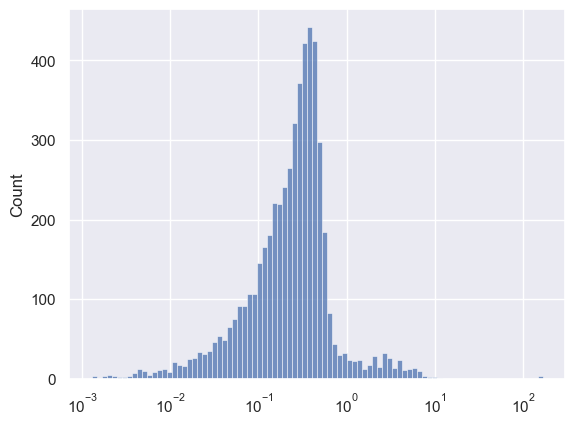

In [20]:
sns.histplot(x=r[r>1e-3], log_scale=True)

In [21]:
cache_fit = True

# least_squares gives a deterministic result that depend on x0, the data, and the otimizer options
# hash the data as well as x0 to decide if we reuse last fit

filename = f"./results/linear-fit-{digest((data,x0))}.npy"

if cache_fit and path.isfile(filename):
    opt = load(filename)
    print("Loaded from cache")
else:
    opt = scipy.optimize.least_squares(residual, x0, loss="soft_l1", xtol=None, verbose=2) 
    
    # save result and remobe some stuff we don't neeed to save.
    del opt.jac
    del opt.active_mask
    del opt.fun
    
    save(filename, opt)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3960e+03                                    9.41e+06    
       1              8         1.3267e+03      6.93e+01       8.22e-02       5.45e+05    
       2             13         1.3041e+03      2.27e+01       3.21e-04       5.94e+04    
       3             14         1.2989e+03      5.12e+00       6.42e-04       4.28e+05    
       4             15         1.2931e+03      5.87e+00       6.42e-04       2.71e+05    
       5             16         1.2898e+03      3.26e+00       6.42e-04       1.90e+05    
       6             17         1.2880e+03      1.80e+00       6.42e-04       1.50e+04    
       7             18         1.2862e+03      1.80e+00       1.28e-03       1.78e+03    
       8             19         1.2838e+03      2.39e+00       2.57e-03       1.51e+03    
       9             20         1.2797e+03      4.13e+00       5.14e-03       3.18e+03    

In [22]:
opt

    message: `ftol` termination condition is satisfied.
    success: True
     status: 2
          x: [ 2.562e-01  2.545e-01 ...  2.197e-01  2.194e-01]
       cost: 801.4000369639522
       grad: [-4.018e-05 -2.361e-04 ...  6.568e-05 -9.266e-06]
 optimality: 8.82582780206576
       nfev: 54
       njev: 39

count    5.388000e+03
mean     3.984199e-01
std      6.907635e-01
min      1.546141e-11
25%      1.291592e-01
50%      2.662327e-01
75%      4.130346e-01
max      9.458932e+00
dtype: float64

<Axes: ylabel='Count'>

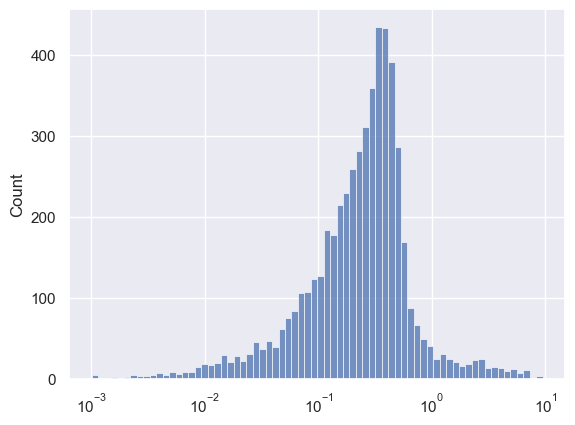

In [23]:
r_opt = np.abs(residual(opt.x))
pd.Series(r_opt).describe()
sns.histplot(x=r_opt[r_opt>1e-3], log_scale=True)

In [24]:
sol = unpack(opt.x, unpack_info)

table(sol)

Pokemons ing fractions,[0.25621964 0.25454238 0.26576942 ... 0.17973256 0.20050849 0.21655525]
Pokemons skill products,[16.72879854 16.70319203 18.42802869 ... 44.72248518 12.80032324 15.26678221]
Charge Strength S,[0.74768376 0.32197698]
Charge Strength M,[0.74482436 0.32281786]
Ingredient Magnet S,[0.7454588 0.32272513]
Cooking Power-Up S,[0.74531272 0.32268548]
Extra Helpful S,[0.74528607 0.32268841]
Charge Energy S,[0.74725556 0.32209371]
Energizing Cheer S,[0.73446867 0.33126043]
Energy for Everyone S,[0.74577335 0.32263778]
Dream Shard Magnet S,[0.7468981 0.32202278]


In [25]:
# Format ing% and skillProduct pretty

res = pd.DataFrame({"Pokemon":pokedex["Pokemon"], "ing%": sol["Pokemons ing fractions"]*100.0, "skill% * skillValue": sol["Pokemons skill products"] })
res.set_index("Pokemon")

,ing%,skill% * skillValue
Pokemon,,
Bulbasaur,25.621964,16.728799
Ivysaur,25.454238,16.703192
Venusaur,26.576942,18.428029
Charmander,20.039873,9.681015
Charmeleon,22.666334,14.051757
Charizard,22.418997,14.007199
Squirtle,26.998547,17.625965
Wartortle,27.056784,17.576355
Blastoise,27.453987,18.436117


In [26]:
# Format main skill growth per level 

growth_display = {}
levels = np.array(list(range(2,7)))
growth_display["Level"] = levels

for record in mainskills.to_dict(orient='records') :   
    
    skillname = record["Skill"]
    params = sol[skillname]
    growth_display[skillname] = params[0]*np.exp(params[1]*levels)
    
df = pd.DataFrame(growth_display)
df.set_index("Level")


,Charge Strength S,Charge Strength M,Ingredient Magnet S,Cooking Power-Up S,Extra Helpful S,Charge Energy S,Energizing Cheer S,Energy for Everyone S,Dream Shard Magnet S,Metronome
Level,,,,,,,,,,
2,1.423586,1.420528,1.421475,1.421083,1.421041,1.423103,1.424631,1.421826,1.422220,1.421707
3,1.964339,1.961769,1.962894,1.962276,1.962223,1.963902,1.984116,1.963208,1.962544,1.964052
4,2.710499,2.709230,2.710533,2.709572,2.709506,2.710212,2.763323,2.710729,2.708147,2.713287
5,3.740090,3.741485,3.742936,3.741460,3.741381,3.740131,3.848541,3.742880,3.737016,3.748337
6,5.160775,5.167042,5.168567,5.166324,5.166230,5.161433,5.359950,5.168038,5.156769,5.178230


In [27]:
# What are the worst points ?

df = data[["Pokemon","ID","Level","MS lvl","NatureP","NatureN","Sub Skill 1","Sub Skill 2","RP"]].copy()

df["fit"] = RP(opt.x)
df["error"] = residual(opt.x)
df["error2"] = df["error"]**2

df = df.sort_values("error2", ascending = False)
df.head(100)

,Pokemon,ID,Level,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
324,Charizard,CharizardMild276Helping Speed MSkill Level Up M,27.0,6,Ingredient Finding,Energy Recovery,Helping Speed M,Skill Level Up M,1514.0,1504.541068,9.458932,89.471401
2087,Togekiss,TogekissGentle103Skill Trigger M,10.0,3,Main Skill Chance,Energy Recovery,Skill Trigger M,,1282.0,1272.700232,9.299768,86.485687
507,Charmeleon,CharmeleonQuiet252Inventory Up MSleep EXP Bonus,25.0,2,Ingredient Finding,Exp Gains,Inventory Up M,Sleep EXP Bonus,1063.0,1054.429780,8.570220,73.448663
346,Charizard,CharizardRash273Helping bonusHelping Speed M,27.0,3,Ingredient Finding,Main Skill Chance,Helping bonus,Helping Speed M,1440.0,1431.456183,8.543817,72.996801
1773,Raticate,RaticateBrave281Inventory Up MSleep EXP Bonus,28.0,1,Speed of Help,EXP Gains,Inventory Up M,Sleep EXP Bonus,1097.0,1088.761752,8.238248,67.868727
270,Butterfree,ButterfreeImpish265Skill Level Up MSleep EXP B...,26.0,5,Energy Recovery,Ingredient Finding,Skill Level Up M,Sleep EXP Bonus,1404.0,1411.096882,-7.096882,50.365736
1996,Sudowoodo,SudowoodoHasty162Berry Finding S,16.0,2,EXP Gains,Energy Recovery,Berry Finding S,,743.0,750.047159,-7.047159,49.662448
1341,Leafeon,LeafeonRelaxed102Inventory Up M,10.0,2,Energy Recovery,EXP Gains,Inventory Up M,,944.0,937.161887,6.838113,46.759794
2570,Butterfree,ButterfreeSassy102Helping bonus,10.0,2,Main Skill Chance,EXP Gains,Helping bonus,,816.0,809.299211,6.700789,44.900576
316,Charizard,CharizardNeutral273Inventory Up MHelping Speed M,27.0,3,-,-,Inventory Up M,Helping Speed M,1299.0,1292.343540,6.656460,44.308453


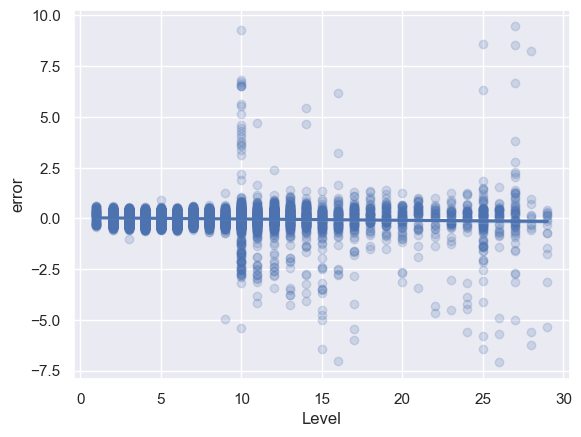

In [28]:
# Plot error vs level

err = df[["Level","error"]]
g = sns.regplot(data=err, x="Level", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

In [29]:
# Do we have a slope ?

linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])

table(linearfit)

intercept,0.0345193
intercept_stderr,0.0196913
pvalue,0.000390374
rvalue,-0.0482986
slope,-0.00619933
stderr,0.00174691


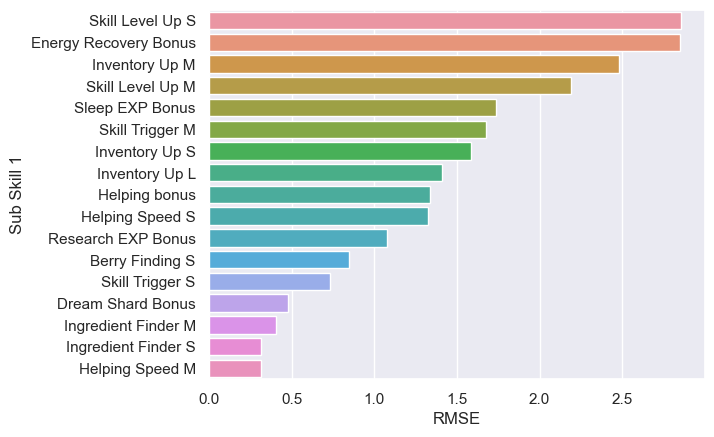

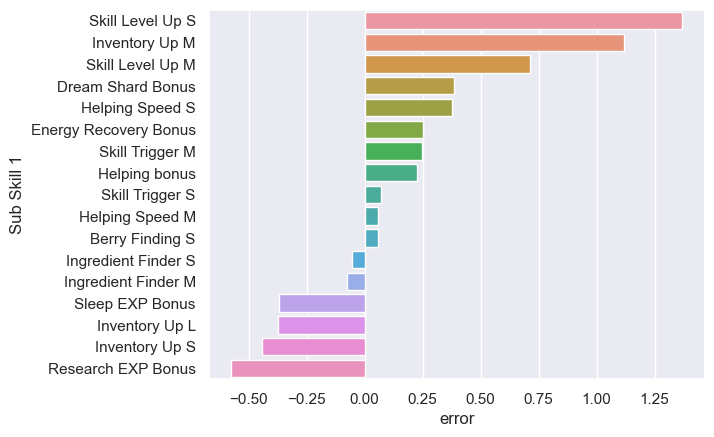

In [30]:
# Let's see what happens at level 10

subskill_err = ( df[["Level", "Sub Skill 1", "error", "error2"]][df["Level"]==10]
                .groupby("Sub Skill 1")
                .mean()
                .sort_values("error2", ascending = False)
                .reset_index() )

subskill_err["RMSE"] = np.sqrt(subskill_err["error2"])

_ = plt.figure()
_ = sns.barplot(data=subskill_err, y="Sub Skill 1", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=subskill_err.sort_values("error", ascending = False), y="Sub Skill 1", x="error")


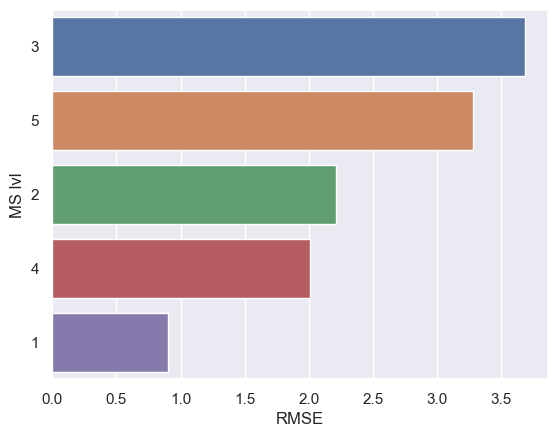

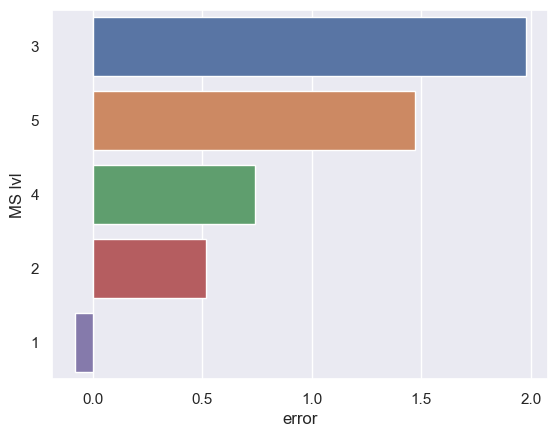

In [31]:
mslvl_err = ( df[["Level", "MS lvl", "error", "error2"]][df["Level"]==10]
                .groupby("MS lvl")
                .mean()
                .sort_values("error2", ascending = False)
                .reset_index() )

mslvl_err["RMSE"] = np.sqrt(mslvl_err["error2"])
mslvl_err["MS lvl"] = mslvl_err["MS lvl"].astype(str)

_ = plt.figure()
_ = sns.barplot(data=mslvl_err, y="MS lvl", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=mslvl_err.sort_values("error", ascending = False), y="MS lvl", x="error")


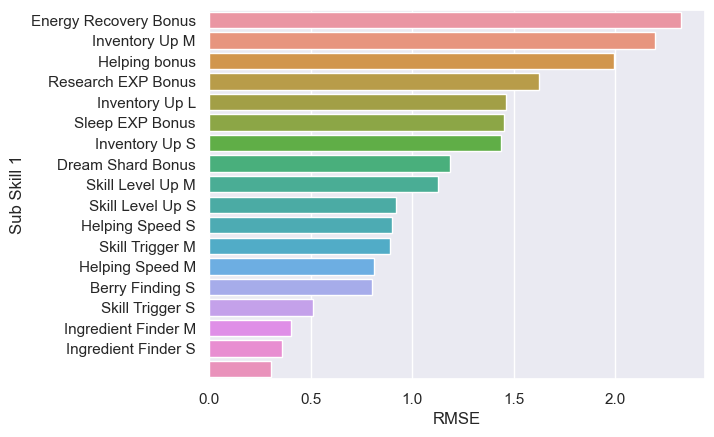

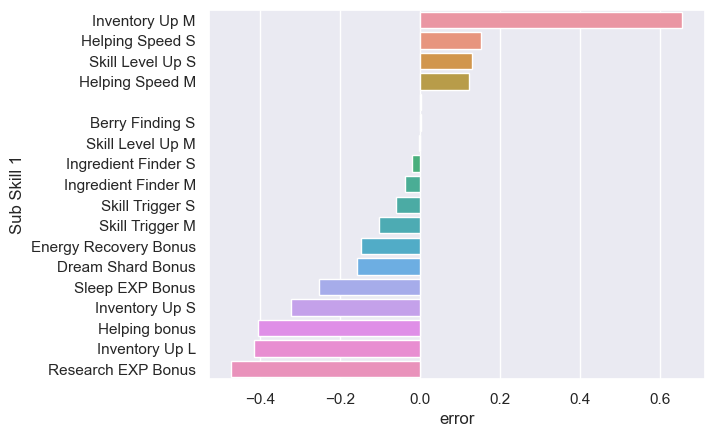

In [32]:
# Do we have more error in some skills ?

errorbyskill1 = (df[["Sub Skill 1","error","error2"]]
                .groupby("Sub Skill 1")
                .mean()
                .sort_values("error2", ascending = False)
                #.rename(columns={"error":"avg abs error"})
                .reset_index() )

errorbyskill1["RMSE"] = np.sqrt(errorbyskill1["error2"])
    
_ = plt.figure()
_ = sns.barplot(data=errorbyskill1, y="Sub Skill 1", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=errorbyskill1.sort_values("error", ascending = False), y="Sub Skill 1", x="error")

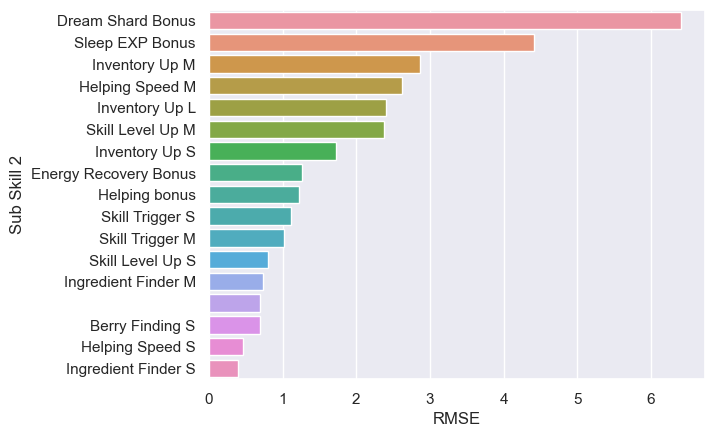

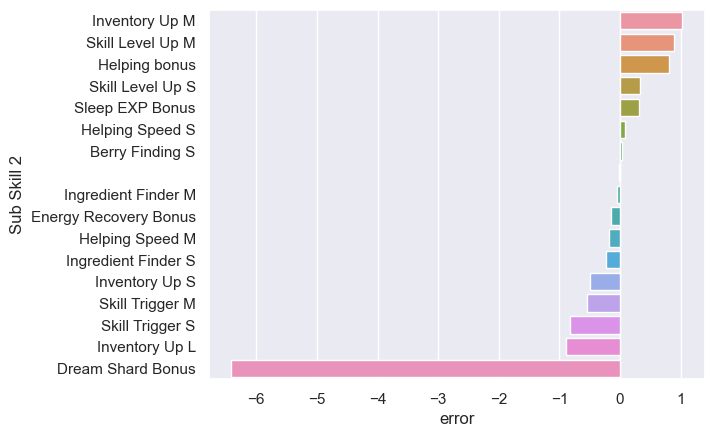

In [33]:
errorbyskill2 = (df[["Sub Skill 2","error","error2"]]
                .groupby("Sub Skill 2")
                .mean()
                .sort_values("error2", ascending = False)
                #.rename(columns={"error":"avg abs error"})
                .reset_index() )

errorbyskill2["RMSE"] = np.sqrt(errorbyskill2["error2"])
    
_ = plt.figure()
_ = sns.barplot(data=errorbyskill2, y="Sub Skill 2", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=errorbyskill2.sort_values("error", ascending = False), y="Sub Skill 2", x="error")